# Brownian-Bridge Barrier Crossing Correction

In Monte Carlo simulations of barrier options, path discretization can miss barrier crossings between time steps. This leads to **upward-biased prices** for knock-out options and **downward-biased prices** for knock-in options.

To address this, we implement the **Brownian Bridge Correction**, a method that estimates the probability of hitting the barrier *between* discrete simulation steps.

#### Down-and-Out Call – Bias vs Time-Step Error

| Symbol | Meaning | Value |
|--------|---------|-------|
| \(S_0\) | Spot price            | **100** |
| \(K\)   | Strike               | 100 |
| \(B\)   | Down barrier         | 90 |
| \(r\)   | Risk-free rate       | 5 % |
| \(\sigma\) | Volatility       | 20 % |
| \(T\)   | Maturity             | 1 yr |
| \(N\)   | Paths (varies)       | — |
| \(M\)   | Time steps (varies)  | — |

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

S0, K, B, r, sigma, T = 100, 100, 90, 0.05, 0.20, 1.0

np.random.seed(42)
disc = np.exp(-r * T)

In [2]:
# GBM path generator
def simulate_paths(S0, r, sigma, T, M, N):
    dt = T / M
    Z = np.random.randn(N, M)
    log_inc = (r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z
    log_paths = np.cumsum(log_inc, axis=1)
    return S0 * np.exp(log_paths), Z

In [3]:
# Plain MC payoff
def payoff_plain(paths):
    knocked = (paths <= B).any(axis=1)
    ST = paths[:, -1]
    return np.where(knocked, 0, np.maximum(ST - K, 0))

### What’s a Brownian Bridge?  

A **Brownian bridge** is a Brownian motion that is *pinned* at two endpoints.  
Given the asset price at $(t_i)$ and $(t_{i+1})$, the intermediate
trajectory is a Brownian bridge.  
For a down-and-out barrier at \(B\):

$
\Pr\!\bigl(\min_{t\in(t_i,t_{i+1})} S_t > B \,\big|\,S_{t_i},S_{t_{i+1}}\bigr)
      = 1 - \exp\!\Bigl(-\frac{2\log(S_{t_i}/B)\log(S_{t_{i+1}}/B)}
                               {\sigma^2\Delta t}\Bigr),
$

so we can correct a discrete path by multiplying each time-step by this
“no-crossing” probability.  
If at any step the bridge crosses the barrier, the option knocks out—even if the coarse grid never touched \(B\).  
This eliminates the **downward bias** of plain Monte-Carlo without adding extra time steps.

In [4]:
# Brownian-Bridge crossing probability
def bb_not_cross(S_prev, S_next, B, sigma, dt):
    """Return P(min_{t∈(0,dt)} S_t > B | endpoints)."""
    a = np.log(S_prev / B)
    b = np.log(S_next / B)
    var = sigma**2 * dt
    prob = 1 - np.exp(-2 * a * b / var)
    prob[b <= 0] = 0.0  # already below barrier at right end
    prob[a <= 0] = 0.0  # already below at left end
    return prob

In [5]:
# Brownian-Bridge corrected payoff
def payoff_bb(paths):
    N, M = paths.shape
    dt = T / M
    survives = np.ones(N, dtype=bool)
    S_prev = np.full(N, S0)
    for j in range(M):
        S_next = paths[:, j]
        p_no_hit = bb_not_cross(S_prev, S_next, B, sigma, dt)
        survives &= np.random.rand(N) < p_no_hit
        S_prev = S_next
    ST = paths[:, -1]
    return np.where(survives, np.maximum(ST - K, 0), 0.0)

In [6]:
def mc_price(payoff_fn, M, N=40_000):
    paths, _ = simulate_paths(S0, r, sigma, T, M, N)
    pay = disc * payoff_fn(paths)
    m = pay.mean()
    ci = 1.96 * pay.std(ddof=1) / np.sqrt(N)
    return m, ci

In [7]:
# Reiner–Rubinstein analytic DO call
def rr_down_out_call(S0, K, B, r, T, sigma):
    lam = (r + 0.5 * sigma**2) / sigma**2
    x1 = np.log(S0 / B) / (sigma * np.sqrt(T)) + lam * sigma * np.sqrt(T)
    y1 = np.log(B**2 / (S0 * K)) / (sigma * np.sqrt(T)) + lam * sigma * np.sqrt(T)
    x2 = x1 - sigma * np.sqrt(T)
    y2 = y1 - sigma * np.sqrt(T)
    A = S0 * norm.cdf(x1) - K * np.exp(-r * T) * norm.cdf(x2)
    B_ = S0 * (B / S0) ** (2 * lam) * norm.cdf(y1) - K * np.exp(-r * T) * (B / S0) ** (
        2 * lam - 2
    ) * norm.cdf(y2)
    return A - B_


true_price = rr_down_out_call(S0, K, B, r, T, sigma)
print(f"Reiner–Rubinstein DO call: {true_price:.4f}")

Reiner–Rubinstein DO call: 7.7731


In [8]:
# Single-run comparison
plain_p, plain_ci = mc_price(payoff_plain, 252)
bb_p, bb_ci = mc_price(payoff_bb, 252)

print(f"Plain MC (miss hits) : {plain_p:.4f} ± {plain_ci:.4f}")
print(f"BB-corrected MC      : {bb_p   :.4f} ± {bb_ci  :.4f}")

Plain MC (miss hits) : 8.8337 ± 0.1429
BB-corrected MC      : 8.6561 ± 0.1433


## Bias versus time-step size

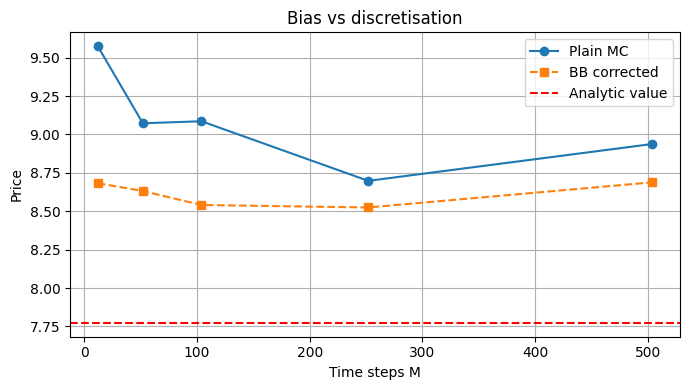

In [9]:
# Bias curves
M_grid = np.array([12, 52, 104, 252, 504])
plain_est, bb_est = [], []
for M_ in M_grid:
    plain_est.append(mc_price(payoff_plain, M_)[0])
    bb_est.append(mc_price(payoff_bb, M_)[0])

plt.figure(figsize=(7, 4))
plt.plot(M_grid, plain_est, "o-", label="Plain MC")
plt.plot(M_grid, bb_est, "s--", label="BB corrected")
plt.axhline(true_price, color="red", ls="--", label="Analytic value")
plt.xlabel("Time steps M")
plt.ylabel("Price")
plt.title("Bias vs discretisation")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

### Conclusions
* Plain time-discrete MC **under-prices** the down-and-out call because it misses barrier hits between sampling dates.  
* Brownian-Bridge correction removes nearly all bias even with coarse meshes (\(M=52\)).  
* Variance remains similar, so BB delivers accuracy “for free.”  
* Combine BB with variance-reduction techniques for production-grade barrier pricing.